In [2]:
VOICED = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW', "ER"])
CMU2VISEME = {"AA":"Ah", "AO":"Ah", "AY":"Ah", "AW":"Ah","AE":"Aa",
              "EY":"Aa","UH":"Uh", "UW":"U","IH": "Ih","IY": "Ih","EH": "Eh","HH": "Eh","UH": "Eh","AH": "Eh",
              "ER": "Eh","OW":"Oo","OY":"Oh","R":"R","D":"LNTD","T": "LNTD","L":"LNTD","N":"LNTD","NG":"LNTD",
              "F":"FV","V":"FV","B":"BP","M":"M","P":"BP","CH":"ShChZh","SH":"ShChZh","ZH":"ShChZh",
              "S": "SZ", "Z": "SZ","DH":"Th", "TH":"Th","G":"GK", "K":"GK","Y":"Y","JH":"J","W":"W",}
VOWELS_SLIDERS_JALI = set(['Ih_pointer', 'Ee_pointer', 'Eh_pointer', 'Aa_pointer', 'U_pointer', 'Uh_pointer'
                           , 'Oo_pointer', 'Oh_pointer', 'Schwa_pointer', 'Eu_pointer', "Ah_pointer"])
CONSONANTS_SLIDERS_JALI = set(["M_pointer", "BP_pointer", "JY_pointer", "Th_pointer", "ShChZh_pointer", "SZ_pointer", "GK_pointer", "LNTD_pointer", "R_pointer", "W_pointer", "FV_pointer"])
CONSONANTS_SLIDERS_NOJAW_JALI = set(["Ya_pointer", "Ja_pointer", "Ra_pointer", "FVa_pointer", "LNTDa_pointer", "Ma_pointer", "BPa_pointer", "Wa_pointer", "Tha_pointer", "GKa_pointer"])
JALI_SLIDERS_SET = set.union(VOWELS_SLIDERS_JALI, CONSONANTS_SLIDERS_JALI, CONSONANTS_SLIDERS_NOJAW_JALI)

In [3]:
class CMU_phonemes_dicts():
    def __init__(self):
        self.vocabs = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH', 'ER', 'EY', 'F', 'G',
                  'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH',
                  'UW', 'V', 'W', 'Y', 'Z', 'ZH'])
        self.vowels = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'ER', 'EY', 
                  'IH', 'IY', 'OW', 'OY', 'UH', 'UW', ])
        self.voiced = set(['M', 'N']).union(self.vowels)
        self.consonants = set(['B', 'CH', 'D', 'DH', 'F', 'G', 'HH', 'JH', 'K', 'L', 'M', 'N', 'NG', 
                              'P', 'R', 'S', 'SH', 'T', 'TH', 'V', 'W', 'Y', 'Z', 'ZH'])
        self.consonants_no_jaw = self.consonants
        self.lip_closer = set(["B", "F", "M", "P", "S", "V"])
        self.lip_rounder = set(["B", "F", "M", "P", "V"])
        self.nasal_obtruents = set(['L', 'N', 'NG', 'T', 'D', 'G', 'K', 'F', 'V', 'M', 'B', 'P'])
        self.fricative = set(["S", "Z", "ZH", "SH", "CH", "F", "V", 'TH'])
        self.plosive = set(["P", "B", "D", "T", "K", "G"])
        self.lip_heavy = set(["W", "OW", "UW", "S", "Z", "Y", "JH", "OY"])
        self.sibilant = set(["S", "Z", "SH", "CH", "ZH"])
class JALI_visemes_dicts():
     def __init__(self):
        self.vowels = set(['Ih_pointer', 'Ee_pointer', 'Eh_pointer', 'Aa_pointer', 'U_pointer', 'Uh_pointer'
                           , 'Oo_pointer', 'Oh_pointer', 'Schwa_pointer', 'Eu_pointer', "Ah_pointer"])
        self.voiced = set(['Ih_pointer', 'Ee_pointer', 'Eh_pointer', 'Aa_pointer', 'U_pointer', 'Uh_pointer'
                           , 'Oo_pointer', 'Oh_pointer', 'Schwa_pointer', 'Eu_pointer', "Ah_pointer", "LNTD_pointer", "LNTDa_pointer"])
        self.consonants_no_jaw = set(["Ya_pointer", "Ja_pointer", "Ra_pointer", "FVa_pointer", "LNTDa_pointer", "Ma_pointer", "BPa_pointer", "Wa_pointer", "Tha_pointer", "GKa_pointer"])
        self.consonants = set(["M_pointer", "BP_pointer", "JY_pointer", "Th_pointer", "ShChZh_pointer", "SZ_pointer", "GK_pointer", "LNTD_pointer", "R_pointer", "W_pointer", "FV_pointer"]) 
        self.lip_closer = set(["M_pointer", "BP_pointer", "FV_pointer", "SZ_pointer"])
        self.lip_rounder = set(["M_pointer", "BP_pointer", "FV_pointer"])
        self.vocabs = self.consonants.union(self.vowels).union(self.consonants_no_jaw)
        self.sibilant = set(["SZ_pointer", "ShChZh_pointer"])
        self.nasal_obtruents = set(["LNTD_pointer", "GK_pointer", "FV_pointer", "M_pointer", "BP_pointer"])
        self.fricative = set(["FV_pointer", "SZ_pointer", "ShChZh_pointer", "Th_pointer"])
        self.plosive = set(["BP_pointer", "LNTDa_pointer", "GK_pointer"])
        self.lip_heavy = set(["Oh_pointer", "W_pointer", "Wa_pointer", "U_pointer", "SZ_pointer", "JY_pointer",
                             "Ya_pointer", "Ja_pointer"])
        self.lip_rounder_to_no_jaw_dict = {"M_pointer":"Ma_pointer", "BP_pointer":"BPa_pointer", "FV_pointer":"FVa_pointer"}
cmu_sets = CMU_phonemes_dicts()
jali_sets = JALI_visemes_dicts()

In [4]:
def generate_basic_viseme_curve(start, end, value, sustain=1, decay = 0.75, onset=0.1, offset=0):
    if end - start < 0.1:
        end = start + 0.1
    interval = []
    interval.append([start-onset, 0])
    # second point is when the belting starts 
    interval.append([start, 1 * value])
    # third point emphasizes decay, it happens 75% down the interval
    if sustain < 1:
        interval.append([start + sustain * (end - start), decay * value])
        # last point is where the furrowing ends
        interval.append([end+offset, 0])
    elif sustain == 1:
        interval.append([end, value])
        # last point is where the furrowing ends
        interval.append([end+offset, 0])
    return interval
def get_kth_neighbour(input_list, i, k):
    if i+k < 0 or i+k >= len(input_list):
        return None
    return input_list[i+k]

In [5]:
from util.SongDataStructure import *
from util.pitch_interval_estimation import *
import numpy as np
import json
from matplotlib import pyplot as plt
import os
from scipy.interpolate import interp1d

In [223]:
# load file for Jali
dir = "E:/MASC/Structured_data/rolling_in_the_deep_adele"
file_name_template = "audio"
lyric = Minimal_song_data_structure(os.path.join(dir, file_name_template+".wav"), os.path.join(dir, file_name_template+".txt"),
                                                                                             os.path.join(dir, "audio_full.TextGrid"))

In [28]:
dir = "E:/MASC/Structured_data/let_her_go"
file_name_template = "vocal_audio_1"
lyric = Minimal_song_data_structure(os.path.join(dir, file_name_template+".wav"), os.path.join(dir, file_name_template+".txt"),
                                   os.path.join(dir, "vocal_audio_1_full.TextGrid"))

In [44]:
dir = "E:/MASC/Structured_data/my_way_frank_sinatra"
file_name_template = "audio_1"
lyric = Minimal_song_data_structure(os.path.join(dir, file_name_template+".wav"), os.path.join(dir, file_name_template+".txt"),
                                   os.path.join(dir, "audio_1__full.TextGrid"))

In [6]:
dir = "C:/Users/evansamaa/Desktop/vowel_model_dataset"
file_name_template = "A_O_2"
lyric = Minimal_song_data_structure(os.path.join(dir, file_name_template+".wav"), os.path.join(dir, file_name_template+".txt"),
                                   os.path.join(dir, "A_O_2.TextGrid"))

In [10]:
# break the thing into sentence structures
sentences = []
current_sentence = []
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] == "EOS_tag":
        sentences.append(current_sentence)
        current_sentence = []
    else:
        current_sentence.append(i)
        if i == len(lyric.phoneme_list) - 1:
            sentences.append(current_sentence)
sentences = sentences[1:] 
# sentence stores the indexes
if len(sentences) == 0:
    sentences = [list(range(0, len(lyric.phoneme_list)))]
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] == ">":
        continue
    if CMU2VISEME[lyric.phoneme_list[i]] == "Oo":
        print(lyric.phoneme_list[i], lyric.phoneme_intervals[i])

In [12]:
phoneme_list = lyric.phoneme_list
phoneme_interval = lyric.phoneme_intervals

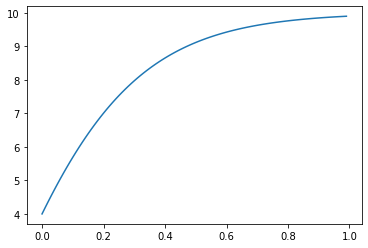

In [13]:
# using tanh function to get a smooth curve
def Viseme_A(peak=None, lowest=None):
    if not peak is None:
        total = np.log((1+peak)/(1-peak))/2
        b = np.log((1+lowest)/(1-lowest))/2
        a = total-b
    else:
        peak = 0.99
        lowest = 0.4
        total = np.log((1+peak)/(1-peak))/2
        b = np.log((1+lowest)/(1-lowest))/2
        a = total-b
    def fn(val, val_max, val_min, max_val = 10):
        val = (val - val_min) / (val_max - val_min)
#         print(val)
#         return (lowest + val * ((peak - lowest)))*max_val
        return np.tanh((val)*a+b) * max_val
#         return (np.exp(val * 8)/np.exp(8) * (peak-lowest) + lowest) * max_val
    return fn
viseme_A = Viseme_A()
plt.plot(np.arange(0, 1, 0.01), viseme_A(np.arange(0, 1, 0.01), 1, 0))

In [14]:
# animate only vowels and see how it goes
viseme_list = []
viseme_intervals = []
pure_phoneme_list = []
max_activation = 8
# threshold_slope = 200 # for formants
threshold_slope = 80 # for pitch


for sentence in sentences:
    sentence_pitch_x, sentence_pitch_y = lyric.get_f_interval([phoneme_interval[sentence[0]][0], 
                                                               phoneme_interval[sentence[-1]][1]])
    sentence_percentiles = np.nanpercentile(sentence_pitch_y, [5, 95])
    sentence_mean = sentence_pitch_y.mean()
    sentence_min = sentence_percentiles[0]
    sentence_max = sentence_percentiles[1]
    for i in range(0, len(sentence)):
        if phoneme_list[sentence[i]] != "EOL_tag" and phoneme_list[sentence[i]] != ">":
            pure_phoneme_list.append(phoneme_list[sentence[i]])
        if phoneme_list[sentence[i]] in VOICED:
            xI, yI = lyric.get_I_interval(phoneme_interval[sentence[i]])
            xf, yf = lyric.get_f_interval(phoneme_interval[sentence[i]])
            xF, yF = lyric.get_F1_interval(phoneme_interval[sentence[i]])
            length_of_interval = xI[-1] - xI[0] 
            if length_of_interval <= 0.35: # if the vowel is approximately a speech vowel, then it is handled like speech
                onset = 0.12
                offset = 0.12
                if phoneme_list[sentence[i]] in cmu_sets.lip_heavy:
                    onset = 0.16
                    offset = 0.16
                value = 7
                sustain = 0.75
                decay = 0.75
                curve = generate_basic_viseme_curve(phoneme_interval[sentence[i]][0], phoneme_interval[sentence[i]][1], value, sustain=sustain, 
                                            decay = decay, onset=onset, offset=offset)
                viseme_intervals.append(curve)
                viseme_list.append(CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer")
            else:
                onset = 0.12
                offset = 0.12
                if phoneme_list[sentence[i]] in cmu_sets.lip_heavy:
                    onset = 0.16
                    offset = 0.16
                control_pts = []
                vib = lyric.compute_vibrato_intervals(yf-savgol_filter(yf, 35, 1), xf, lyric.dt)
                vib_interval_indexs = lyric.get_subarrays_indexes_from_time_interval(vib, xf)
                for vib_int in vib_interval_indexs:
                    yf[vib_int[0]:vib_int[1]] = yf[vib_int[0]:vib_int[1]].mean()
                slopes_f, intervals_f = efficient_piece_wise_linear_intervals(xf, yf)
                kpx_f, kpy_f = get_key_points(xf, yf, intervals_f, slopes_f)
#                 plt.plot(kpx_f, kpy_f)
#                 plt.plot(xf, yf)
#                 plt.show()
                # onset and offset of these would be the same as regular vowels 
                control_pts.append([phoneme_interval[sentence[i]][0] - onset, 0])
                
                # here I will determine the average pitch when singing this vowel. Which is used to 
                avg_pitch = 0
                total_weight = 0
                pitch_values = []
                for si in range(0, len(slopes_f)):
                    if abs(slopes_f[si]) <= threshold_slope:
                        avg_pitch = avg_pitch + (yf[intervals_f[si][0]] * (intervals_f[si][1] - intervals_f[si][0]))
                        pitch_values.append(yf[intervals_f[si][0]])
                        total_weight = total_weight + (intervals_f[si][1] - intervals_f[si][0])
                if avg_pitch == 0:
                        avg_pitch = yf.mean()
                        total_weight = 1
                pitch_values = np.array(pitch_values)
                avg_pitch = avg_pitch / total_weight
                
                # now find the first key point - i.e. the beginning of the first plateau
                # the first key point is defined as the point where a plateau first appears 
                # it can also be the first point that reaches the same pitch as the first plateau
                # this ensures that undetected vibrato will not mess up with the timing
                # and cause the mouth to open too slowly 
                start = 0
                for si in range(0, len(slopes_f)):
                    if abs(slopes_f[si]) <= threshold_slope:
                        interp_pitch = interp1d(kpx_f, kpy_f)
                        start = si
                        end_x_search = min(xf[intervals_f[si][0]], kpx_f[-1])
                        begin_x_search = xf[intervals_f[0][0]]
                        x_range = np.arange(begin_x_search, end_x_search, 0.01)
                        f_range = interp_pitch(x_range)
                        first_val = interp_pitch(xf[intervals_f[si][0]])
                        for ssi in range(0, x_range.shape[0]-1):
                            if ((f_range[ssi] < first_val) and  (f_range[ssi+1] >= first_val) 
                                or (f_range[ssi] >= first_val) and  (f_range[ssi+1] < first_val)):
                                end_x_search = x_range[ssi]
                                break
#                         if yf.min() > sentence_mean:
#                             viseme_A_alt = Viseme_A(0.8, 0.99)
#                             val0 = viseme_A_alt(yf[intervals_f[si][0]], pitch_values.max(), yf.min())
#                             val1 = viseme_A_alt(yf[intervals_f[si][1]], pitch_values.max(), yf.min())
#                         else:
#                             val0 = viseme_A(yf[intervals_f[si][0]], pitch_values.max(), yf.min())
#                             val1 = viseme_A(yf[intervals_f[si][1]], pitch_values.max(), yf.min())
                        val0 = viseme_A(yf[intervals_f[si][0]], yf.max(), min(yf.min(), sentence_mean))
                        val1 = viseme_A((yf[intervals_f[si][1]] + yf[intervals_f[si][0]])/2, yf.max(), min(yf.min(), sentence_mean))

#                         dif = (xf[intervals_f[si][1]] - end_x_search) * 0.7
                        dif = max((xf[intervals_f[si][1]] - xf[intervals_f[si][0]]) * 0.8, xf[intervals_f[si][1]] - xf[intervals_f[si][0]]- 0.1)
                        control_pts.append([end_x_search, val0])
                        control_pts.append([xf[intervals_f[si][0]] + dif, val1])                 
                        break
                        
#                 plt.plot(xf, viseme_A(yf, yf.max(), min(yf.min(), sentence_mean)))
#                 plt.show()
#                 plt.plot(xI, yI)
#                 plt.show()
                # now determine intermediate key-points that correlates with lipshape
                for si in range(start+1, len(slopes_f)):
                    val0 = viseme_A(yf[intervals_f[si][0]], yf.max(), min(yf.min(), sentence_mean))
                    val1 = viseme_A((yf[intervals_f[si][1]] + yf[intervals_f[si][0]])/2, yf.max(), min(yf.min(), sentence_mean))
                    dif = max((xf[intervals_f[si][1]] - xf[intervals_f[si][0]]) * 0.8, xf[intervals_f[si][1]] - xf[intervals_f[si][0]]- 0.1)
                    if abs(slopes_f[si]) <= threshold_slope:
                        control_pts.append([xf[intervals_f[si][0]], val0])
                        control_pts.append([xf[intervals_f[si][0]] + dif, val1])
                    
                for si in range(len(slopes_f)-1, -1, -1):
                    if abs(slopes_f[si]) <= threshold_slope:
                        control_pts.append([xf[intervals_f[si][1]], viseme_A(yf[intervals_f[si][1]], 
                                                                             yf.max(), yf.min())])
                        break
                control_pts.append([phoneme_interval[sentence[i]][1] + offset, 0])
                viseme_intervals.append(control_pts)
                viseme_list.append(CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer")   
                
        ### Dealing with consonants here. I'm just going to insert them between without too much modification
        ### it will about the same as pure Jali
        elif phoneme_list[sentence[i]] in cmu_sets.consonants:
            onset = 0.12
            offset = 0.12
            if CMU2VISEME[phoneme_list[sentence[i]]] in jali_sets.nasal_obtruents and phoneme_interval[sentence[i]][1] - phoneme_interval[sentence[i]][0] > 1/20:
                viseme_jali = CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer"
            else:
                if phoneme_list[sentence[i]] == "HH" or phoneme_list[sentence[i]] in cmu_sets.sibilant:
                    viseme_jali = CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer"
                else:
                    viseme_jali = CMU2VISEME[phoneme_list[sentence[i]]] + "a_pointer"
            if viseme_jali in jali_sets.lip_heavy:
                onset = 0.16
                offset = 0.16
            start = phoneme_interval[sentence[i]][0]
            end = phoneme_interval[sentence[i]][1]
            if (end - start) <= 0.1:
                value = 6
                sustain = 0.75
                decay = 0.75
            elif (end - start) <= 0.3:
                value = 6
                sustain = 0.75
                decay = 0.75
            else:
                value = 8
                sustain = 0.75
                decay = 0.75
            if phoneme_list[sentence[i]] in cmu_sets.lip_closer:
                value = 10
            viseme_curve = generate_basic_viseme_curve(start, end, value, sustain=sustain, decay=decay, onset=onset, offset=offset)
            viseme_list.append(viseme_jali)
            viseme_intervals.append(viseme_curve)   

ValueError: A value in x_new is below the interpolation range.

In [49]:
for i in range(0, len(viseme_list)):
    if lyric.phoneme_list[i] == ">":
        continue
    if viseme_list[i] == "Oo_pointer":
        print(viseme_list[i], viseme_intervals[i])

Oo_pointer [[9.347747128131338, 0], [9.507747128131339, 7], [9.711093032032835, 5.25], [9.938875, 0]]


In [50]:
# create overlap between visemes so that they are more fluid
for i in range(1, len(viseme_list)):
    # re-order all the clips so that 
    if pure_phoneme_list[i] in cmu_sets.vowels:
        prev_vowel = -1
        for si in range(i-1, -1, -1):
            if pure_phoneme_list[si] in cmu_sets.vowels:
                prev_vowel = si
                break
        if prev_vowel > -1 and viseme_list[i] != viseme_list[prev_vowel]:
            interval_i = viseme_intervals[i]
            interval_i.sort(key=lambda x:x[0])
            interval_prev = viseme_intervals[prev_vowel]
            interval_prev.sort(key=lambda x:x[0])
            if interval_i[0][0] <= interval_prev[-1][0]:
                # there is an overlap
                interval_prev[-2][0] = interval_i[1][0]
                interval_prev[-1][0] = interval_i[1][0] + 0.12
                viseme_intervals[prev_vowel] = interval_prev

In [51]:
# enforce co-articulation rules of consonants
viseme_list_final = []
viseme_intervals_final = []
pure_phoneme_list_final = []
i = 0;

while i < len(viseme_list):
    increment = 1
    i_next = min(i + 1, len(viseme_list)-1)
    if (viseme_list[i_next] == viseme_list[i] and viseme_intervals[i][-1][0] >= viseme_intervals[i_next][0][0]):
        # remove repeated vowels or consonants
        viseme_list_final.append(viseme_list[i_next])
        int_curr = viseme_intervals[i]
        int_next = viseme_intervals[i_next]
        viseme_interval = [int_curr[0], [int_curr[1][0], max(int_curr[1][1], int_next[1][1])], 
                           [int_next[2][0], max(int_curr[2][1], int_next[2][1])], int_next[3]]
        viseme_intervals_final.append(viseme_interval)
        pure_phoneme_list_final.append(pure_phoneme_list[i])
        if viseme_list[i_next] in jali_sets.lip_rounder:
            viseme_list_final.append(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i_next]])
            viseme_intervals_final.append(viseme_interval)
        increment = 2
    elif viseme_list[i] in jali_sets.lip_heavy:
        # if the viseme is a lip-heavy viseme, the it is voice simutaneously as nearby labial dental and bilabials 
        current_interval = viseme_intervals[i] 
        if not get_kth_neighbour(viseme_list, i, -1) is None:
            if current_interval[0][0] <= viseme_intervals[i-1][-1][0] - lyric.dt and viseme_intervals[i-1][-1][0] in jali_sets.lip_rounder:
                current_interval[0][0] = viseme_intervals[i-1][0][0]
                current_interval[1][0] = viseme_intervals[i-1][1][0]
        if not get_kth_neighbour(viseme_list, i, +1) is None:
            if current_interval[-1][0] <= viseme_intervals[i+1][0][0] - lyric.dt and viseme_intervals[i+1][-1][0] in jali_sets.lip_rounder:
                current_interval[2][0] = viseme_intervals[i+1][0][0]
                current_interval[3][0] = viseme_intervals[i+1][1][0]
        viseme_list_final.append(viseme_list[i])
        viseme_intervals_final.append(current_interval)
        if viseme_list[i] in jali_sets.lip_rounder:
            viseme_list_final.append(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i]])
            viseme_intervals_final.append(current_interval)
        pure_phoneme_list_final.append(pure_phoneme_list[i])
    else:
        viseme_list_final.append(viseme_list[i])
        viseme_intervals_final.append(viseme_intervals[i])
        if viseme_list[i] in jali_sets.lip_rounder:
            viseme_list_final.append(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i]])
            viseme_intervals_final.append(viseme_intervals[i])
        pure_phoneme_list_final.append(pure_phoneme_list[i])
    i = i + increment

In [52]:
for i in range(0, len(viseme_list_final)):
    if viseme_list_final[i] == ">":
        continue
    if viseme_list_final[i] == "Oo_pointer":
        print(viseme_list_final[i], viseme_intervals_final[i])

Oo_pointer [[9.347747128131338, 0], [9.507747128131339, 7], [9.794875000000001, 5.25], [9.914875, 0]]


In [53]:
for i in range(0, len(viseme_list_final)-1):
    # re-order all the clips so that 
    if pure_phoneme_list_final[i] in cmu_sets.vowels:
        next_vowel = -1
        for si in range(i+1, len(viseme_list_final)):
            if pure_phoneme_list_final[si] in cmu_sets.vowels:
                next_vowel = si
                break
        if next_vowel > -1:
            interval_i = viseme_intervals_final[i]
            interval_i.sort(key=lambda x:x[0])
            interval_next = viseme_intervals_final[next_vowel]
            interval_next.sort(key=lambda x:x[0])
            if interval_i[-1][0] <= interval_next[0][0]:
                # there is no overlap 
                interval_i[-1][1] = interval_i[-2][1]/2
                interval_i.append([interval_next[0][0], interval_i[-1][1] * 0.75])
                interval_i.append([interval_next[1][0], 0])
                viseme_intervals_final[i] = interval_i

In [54]:
# pass 3
# set this up
prev_slider_dict = {}
for i in range(0, len(list(jali_sets.vocabs))):
    prev_slider_dict[list(jali_sets.vocabs)[i]] = -1
viseme_list_final_final = []
viseme_intervals_final_final = []
i = 0  
while i < len(viseme_list_final):
    increment = 1
    prev_viseme = viseme_list_final[i]
    # if the previous instance of the current viseme is not -1
    if prev_slider_dict[viseme_list_final[i]] != -1:
        current_interval = viseme_intervals_final[i]
        prev_interval = viseme_intervals_final_final[prev_slider_dict[viseme_list_final[i]]]
        if (current_interval[1][0] >= prev_interval[2][0] and current_interval[0][0] <= prev_interval[3][0]):
            interval = prev_interval[:-1] + current_interval[1:]
            viseme_intervals_final_final[prev_slider_dict[viseme_list_final[i]]] = interval
        elif (current_interval[1][0] <= prev_interval[2][0]):
            interval = prev_interval[0:-2] + current_interval[1:]
            viseme_intervals_final_final[prev_slider_dict[viseme_list_final[i]]] = interval
        else:
            viseme_list_final_final.append(viseme_list_final[i])
            viseme_intervals_final_final.append(viseme_intervals_final[i])
                
    else:        
        viseme_list_final_final.append(viseme_list_final[i])
        viseme_intervals_final_final.append(viseme_intervals_final[i])
        
    prev_slider_dict[viseme_list_final[i]] = len(viseme_list_final_final) - 1
    i = i + increment

In [55]:
lyric.compute_self_vibrato_intervals()
vib_ctrl_pts = []
for k in lyric.vibrato_intervals:
    if len(k) > 0:
        for m in k:
            vib_ctrl_pts.append(m)


32.78324263038549
32.720742630385494
32.68324263038549
32.64824263038549
32.59324263038549
32.57574263038549
32.49324263038549
32.50324263038549
13.803242630385489
13.713242630385489
13.733242630385488
13.61324263038549
19.833242630385485
19.813242630385485
19.753242630385486
19.743242630385485
19.663242630385486
19.673242630385484
26.893242630385487
26.795742630385487
26.883242630385485
26.688242630385485
26.803242630385487
26.580742630385483
26.713242630385487
26.473242630385485
26.603242630385488
26.365742630385487
26.553242630385487
26.258242630385485
29.843242630385486
29.811992630385486
29.823242630385487
29.720742630385484
29.803242630385487
29.629492630385485
29.773242630385486
29.538242630385486
29.753242630385486
29.446992630385484
29.733242630385487
29.355742630385485
29.723242630385485
29.264492630385487
29.663242630385486
29.173242630385484
29.613242630385486
29.081992630385486
29.593242630385486
28.990742630385487
29.573242630385487
28.899492630385488
29.533242630385487
2

In [56]:
output ={"viseme":[viseme_list_final_final, viseme_intervals_final_final],
#         "brow":[brow_movement, brow_ctrl_points, finer_brow_raise_ctrl_points, finer_brow_furrow_ctrl_points],
#         "blink":[eye_movement, eye_ctrl_points],
        "jaw":[[0, 6]],
        "lip":[[0, 6]], 
        "vib":vib_ctrl_pts}
jsonoutput = json.dumps(output)
with open(os.path.join(dir, file_name_template+'_jali_sing.json'), 'w') as outfile:
    json.dump(jsonoutput, outfile)